# Spotify Weighting System
The weighting system used to rank artists is based on data downloaded from Spotify on my usage. It shows how much time I spend listening to a song which I can then use to find how much per artist. 

The per artist weighting system is based on three equally important factors: 
- Average listen time (t)
- Total listens (L)
- Listen recency (R)

***Relevance = t X L X R***

### Imports and setup

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, date

In [20]:
stream_hist = pd.read_json('../data/Spotify_UsageData_29May2020/StreamingHistory0.json')

# Set index as date
stream_hist = stream_hist.set_index('endTime')

# Sort values
stream_hist = stream_hist.sort_values(by='endTime', ascending=False)

# Set index as Timestamp
stream_hist.index = pd.to_datetime(stream_hist.index)

stream_hist.head(5)

,artistName,trackName,msPlayed
endTime,,,
2019-11-26 18:56:00,New York Dolls,Personality Crisis,0
2019-11-26 18:56:00,Steve Miller Band,Fly Like An Eagle,0
2019-11-26 18:56:00,Canned Heat,Going Up The Country,3300
2019-11-26 18:56:00,Black Sabbath,Paranoid,1382
2019-11-26 18:56:00,Boston,More Than a Feeling,120988


# &nbsp;

## 1. Average Listen Time
This section finds the average listen per artist and compares it to the average.

In [21]:
mean_played = stream_hist.msPlayed.mean()
mean_played

44173.3851

Group the DataFram by the artist's name and finds the average listen for that artist.

In [22]:
# Listen time ranges per artist
listen_ranges = stream_hist.groupby('artistName').msPlayed.agg('mean').sort_values(ascending=False)
listen_ranges

artistName
The Tim Ferriss Show    877573.0
Harvey McKay            432853.0
Crackazat               396623.0
Cameo                   393573.0
Tiger Stripes           384728.0
                          ...   
The Undisputed Truth         0.0
The Vines                    0.0
OC                           0.0
O.T. Genasis                 0.0
Lil Xan                      0.0
Name: msPlayed, Length: 1137, dtype: float64

## &nbsp;

### Artist vs Average

In [23]:
# Deducts total mean listen time from each artist's
artist_relevance = listen_ranges.map(lambda x: x - mean_played)
artist_relevance

artistName
The Tim Ferriss Show    833399.6149
Harvey McKay            388679.6149
Crackazat               352449.6149
Cameo                   349399.6149
Tiger Stripes           340554.6149
                           ...     
The Undisputed Truth    -44173.3851
The Vines               -44173.3851
OC                      -44173.3851
O.T. Genasis            -44173.3851
Lil Xan                 -44173.3851
Name: msPlayed, Length: 1137, dtype: float64

### &nbsp;

#### Plot 
The top 20 artists are plotted below.

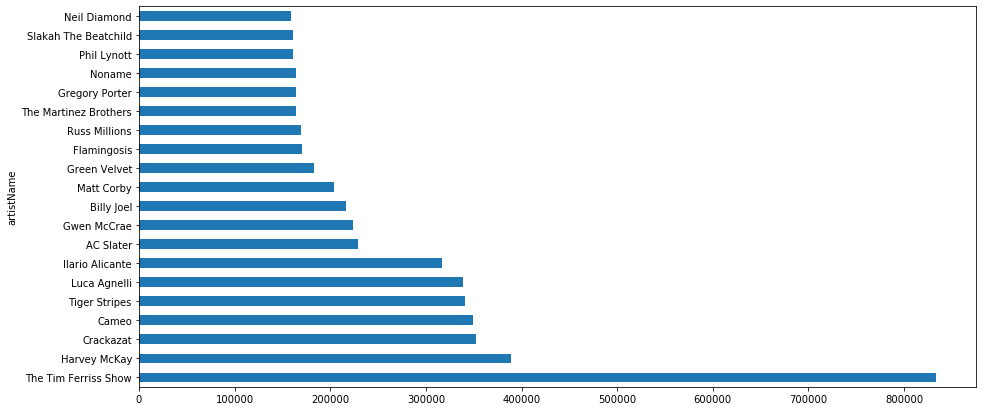

In [24]:
def bar_plot20(data_s):
    """The top 20 of a DataSeries in a bar plot"""
    fig, ax = plt.subplots(figsize=(15,7))
    return data_s.head(20).plot.barh(ax=ax)

bar_plot20(artist_relevance)

## &nbsp;

### Remove podcasts
The most listened per artist are mostly podcasts and I'd like to exclude these from the analysis. A quick way to do this would be to limit only songs with a listen time less than 6 minutes. **This is obviously not the optimal way to decide whether it's a podcast; comparing the song name to Spotify's API would be better.**

#### Drop rows based on time
Any tracks more than 6 minutes (360000ms) are dropped.

In [25]:
stream_hist = stream_hist.drop(stream_hist[stream_hist.msPlayed > 360000].index)
stream_hist.head(5)

,artistName,trackName,msPlayed
endTime,,,
2019-11-26 18:56:00,New York Dolls,Personality Crisis,0
2019-11-26 18:56:00,Steve Miller Band,Fly Like An Eagle,0
2019-11-26 18:56:00,Canned Heat,Going Up The Country,3300
2019-11-26 18:56:00,Black Sabbath,Paranoid,1382
2019-11-26 18:56:00,Boston,More Than a Feeling,120988


In [26]:
def get_listen_time(data_f):
    """Passed DataFrame and returns graded, sorted Data Series"""
    # Group artists, get average and sort  
    listen_ranges = data_f.groupby('artistName').msPlayed.agg('mean').sort_values(ascending=False)
    # Subtract average from each artist
    listen_time = listen_ranges.map(lambda x: x - listen_ranges.mean())
    # Grade listens from 0-1-divides each value by max
    return listen_time.map(lambda x: x / listen_time.max())

listen_time_graded = get_listen_time(stream_hist)

### &nbsp;

#### Plot with adjustments
I haven't heard of many of the artists in the graph. I think counting total listens might solve this.

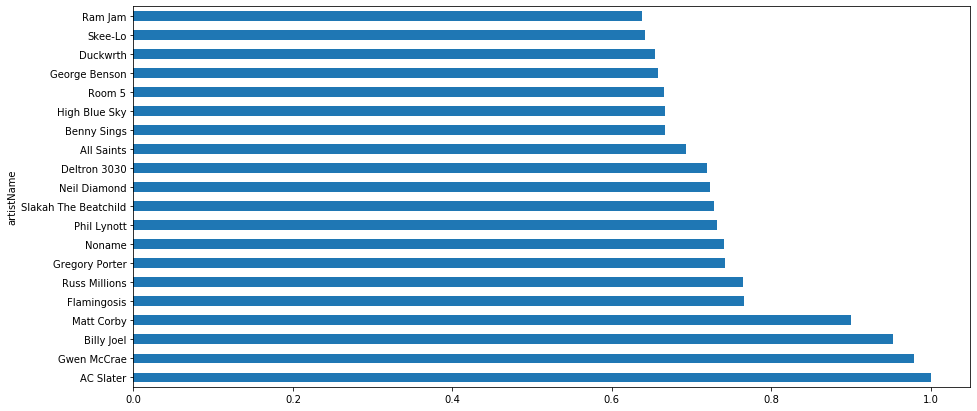

In [27]:
bar_plot20(listen_time_graded)

**Can't say I know many of these artists. Reducing the weight this parameter might be done in future.**

# &nbsp;

## 2. Total Listens
This section counts the total number of listens per artist

In [28]:
def get_total_listens(data_f):
    """Pass DataFrame and returns graded, sorted Data Series"""
    # Group and sort artists
    songs_per_artist = data_f.groupby('artistName').artistName.count().sort_values(ascending=False)
    # Returns each row divided by the max
    return songs_per_artist.map(lambda x: x / songs_per_artist.max())

total_songs = get_total_listens(stream_hist)

## &nbsp;

### Plot Most Total Listens

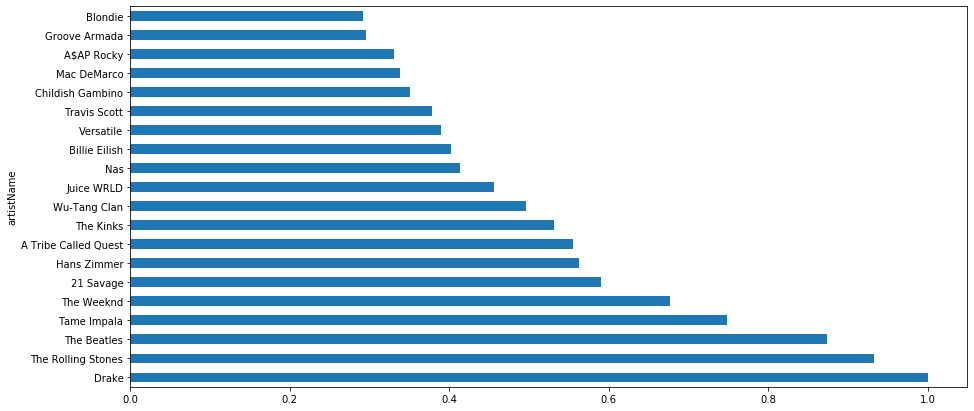

In [29]:
bar_plot20(total_songs)

**This seems a little more reflective of my actual listens. In future weighting I might give more weight to this.**

# &nbsp;

## 3. Listen Recency
This ranks the artist based on how much of their listens have been recent. This will get the most recent date and award points based on how few days have passed since the most recent date.

### Days passed since the first entry
Finds the number of minutes passed since the most recent date. The value is divides 1 so that the most recent is 1 and the less recent going towards zero.

In [67]:
def get_recency(data_f):
    """Pass DataFrame and return Series of graded averages"""
    
    # Get most recent date
    recent_date = data_f.index[0]
    
    # Iterate index and grade average 
    mins_since=[]
    for t_stamp in data_f.index:
        # Gets time in minutes since most recent
        minute = (recent_date - t_stamp) / np.timedelta64(1, 'm')
        if minute == 0.0:
            # If no time has passed max of 1 is given
            mins_since.append(1)
        else:
            # Divde 1 by time passed
            mins_since.append(1 / minute)
            
    data_f.recencyScore = mins_since
    # Get average
    mean_recency = data_f.recencyScore.mean()
    # Group and sort
    artist_recency = data_f.groupby('artistName').recencyScore.agg('mean').sort_values(ascending=False)
    # Subtract 
    return artist_recency.map(lambda x: x - mean_recency)

recency = get_recency(stream_hist)
recency

artistName
New York Dolls                         0.998591
Frank Zappa                            0.500666
Black Sabbath                          0.498598
Rush                                   0.498591
David Lee Roth                         0.498591
                                         ...   
Brother Ali                           -0.001405
The Aztext Ft Double Ab and Rich Mo   -0.001405
MC Hammer                             -0.001405
House Of Pain                         -0.001405
Sage Francis                          -0.001405
Name: recencyScore, Length: 1128, dtype: float64

## &nbsp;
### Artist's Average Recency Score

In [61]:
# # Listen time ranges per artist
# def get_avg_recency(recency_score):
#     """Pass recency score to get average of all artists"""
#     # Get average of all
#     mean_recency = recency_score.mean()
#     # Group by artist and sort
#     artist_recency = stream_hist.groupby('artistName').recencyScore.agg('mean').sort_values(ascending=False)
#     # Subtract each from average and return
#     return artist_recency.map(lambda x: x - mean_recency)

# avg_recency = get_avg_recency(recency)
# avg_recency

artistName
New York Dolls                         0.998591
Frank Zappa                            0.500666
Black Sabbath                          0.498598
Rush                                   0.498591
David Lee Roth                         0.498591
                                         ...   
Brother Ali                           -0.001405
The Aztext Ft Double Ab and Rich Mo   -0.001405
MC Hammer                             -0.001405
House Of Pain                         -0.001405
Sage Francis                          -0.001405
Name: recencyScore, Length: 1128, dtype: float64

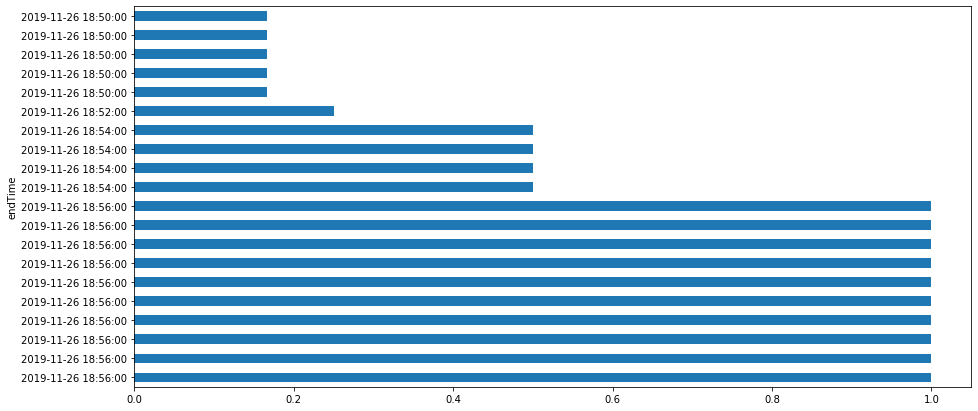

In [32]:
bar_plot20(recency)

**Can't say I know many of these artists. Reducing the weight this parameter might be done in future.**

# &nbsp;

## 4. Combine Weights
Combine all weights:
- Average listen time (t) = listen_time_graded
- Total listens (L) = songs_per_artist
- Listen recency (R) = artist_recency

***Relevance = t X L X R***

### Join Series

In [37]:
# Create DataFrame for weights
artist_relevance = pd.DataFrame() 
artist_relevance['listenTime'] = listen_time_graded
artist_relevance['totalListens'] = total_songs
artist_relevance['listenRecency'] = avg_recency

artist_relevance.head()

,listenTime,totalListens,listenRecency
artistName,,,
AC Slater,1.000000,0.003937,-0.001374
Gwen McCrae,0.979427,0.011811,-0.001304
Billy Joel,0.952716,0.003937,-0.001401
Matt Corby,0.900019,0.003937,-0.001400
Flamingosis,0.766186,0.003937,-0.001400


&nbsp;
### Combine Values

In [39]:
artist_relevance['combinedScore'] = listen_time_graded + total_songs + avg_recency
artist_relevance = artist_relevance.sort_values(by='combinedScore', ascending=False)

artist_relevance.head()

,listenTime,totalListens,listenRecency,combinedScore
artistName,,,,
Drake,0.136953,1.000000,-0.001393,1.135560
The Rolling Stones,0.174586,0.933071,-0.001268,1.106389
AC Slater,1.000000,0.003937,-0.001374,1.002563
Gwen McCrae,0.979427,0.011811,-0.001304,0.989934
The Weeknd,0.292530,0.677165,-0.001382,0.968313


&nbsp;
### Plot Score

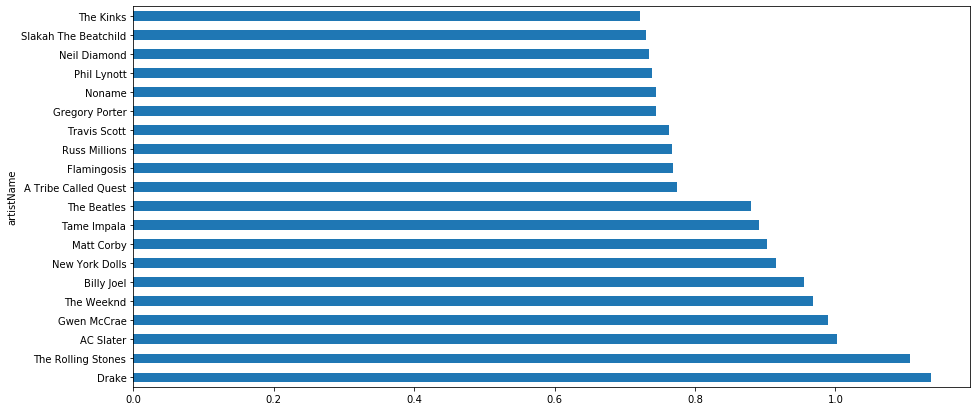

In [40]:
bar_plot20(artist_relevance.combinedScore)

# &nbsp;

## 5. Use Entire Streaming History

In [1]:
from glob import glob

# Finds all relevant files
filenames = glob('../data/Spotify_UsageData_29May2020/StreamingHistory*.json')
dataframes = [pd.read_json(f) for f in filenames]

combined_streams = pd.concat(dataframes)

# Set index as date
combined_streams = combined_streams.set_index('endTime')

# Sort values
combined_streams = combined_streams.sort_values(by='endTime', ascending=False)

# Set index as Timestamp
combined_streams.index = pd.to_datetime(combined_streams.index)

combined_streams = combined_streams.drop(combined_streams[combined_streams.msPlayed > 360000].index)
combined_streams.head()

NameError: name 'pd' is not defined

&nbsp;
### Plot Each Weight

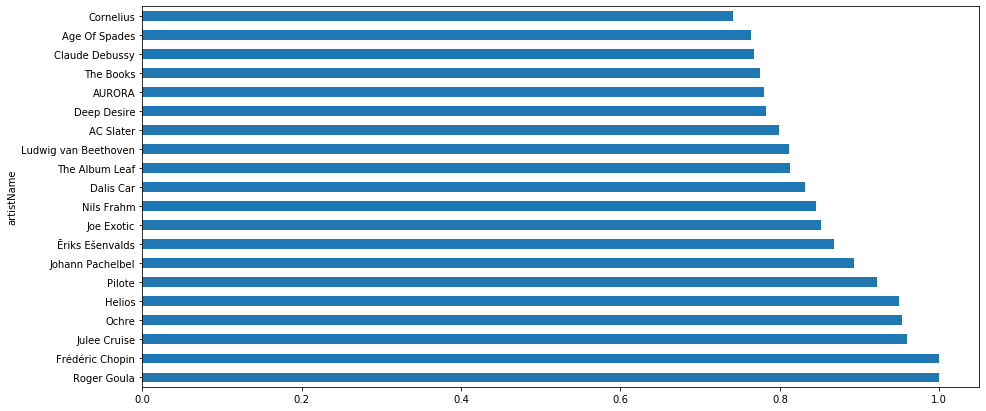

In [43]:
listen_time = get_listen_time(combined_streams)
bar_plot20(listen_time)

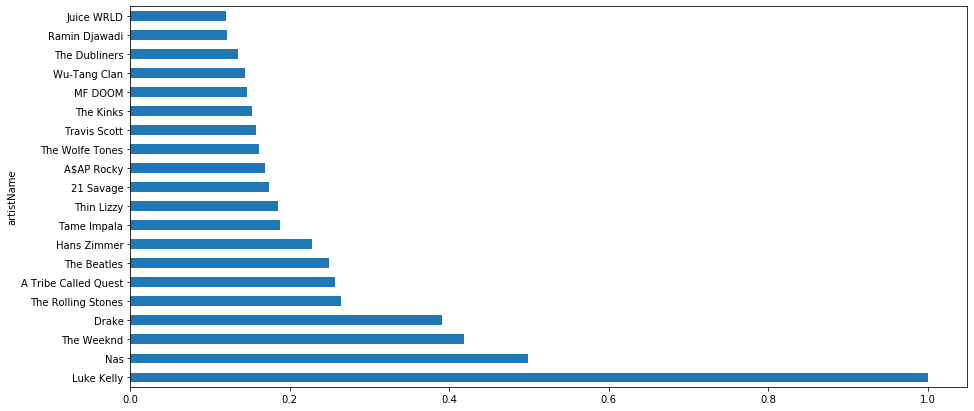

In [74]:
total_songs = get_total_listens(combined_streams)
bar_plot20(total_songs)

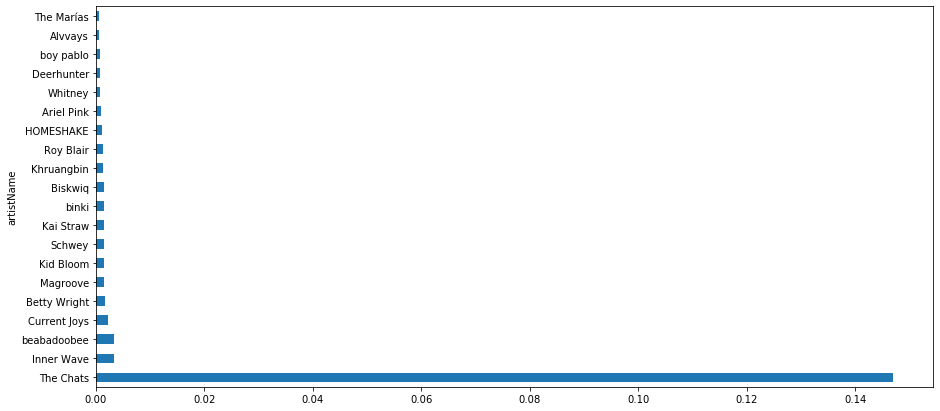

In [70]:
recency = get_recency(combined_streams)
bar_plot20(recency)

&nbsp;
### Combine & Plot

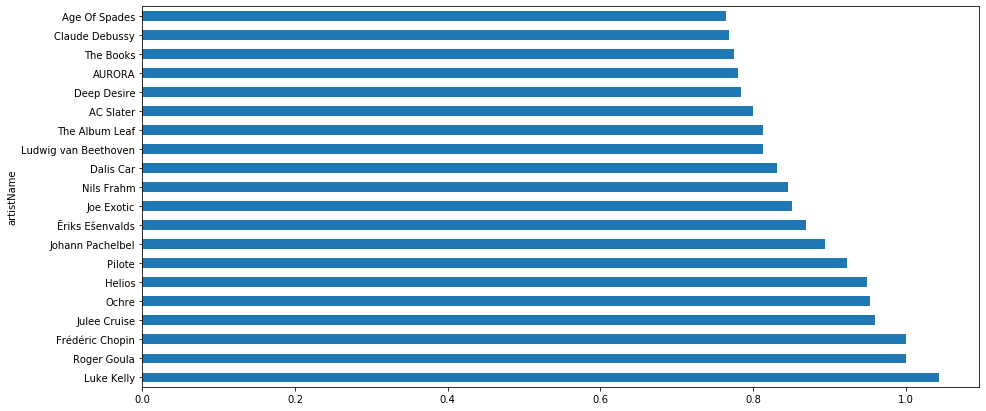

In [77]:
# Create DataFrame for weights
artist_relevance = pd.DataFrame() 
artist_relevance['listenTime'] = listen_time
artist_relevance['totalListens'] = total_songs
artist_relevance['listenRecency'] = recency

artist_relevance['combinedScore'] = listen_time + total_songs + recency
artist_relevance = artist_relevance.sort_values(by='combinedScore', ascending=False)
# artist_relevance.combinedScore.max()
bar_plot20(artist_relevance.combinedScore)

In [76]:
artist_relevance.listenRecency.isnull()

artistName
AC Slater           False
Gwen McCrae         False
Billy Joel          False
New York Dolls      False
Matt Corby          False
                    ...  
Ocean Wisdom        False
Rodney Atkins       False
Johan Söderqvist    False
Henry Jackman       False
DEVO                False
Name: listenRecency, Length: 2019, dtype: bool

**The Alexa in my kitchen is skewing the results**